In [1]:
import torch
import os
import cv2
import imgaug as ia
import numpy as np
import sys
import json

from imgaug import augmenters as iaa

from collections import defaultdict

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

from torchvision.models import resnet18 as resnet18
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
!pip install imgaug wandb

  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.9
    Uninstalling decorator-5.0.9:
      Successfully uninstalled decorator-5.0.9


## Логирование процесса обучения

Будем отправлять логи обучения (значение функции потерь, метрики качества) в сервис Weights & Biases - https://wandb.ai. Тогда к ним можно будет легко получить доступ через интернет и следить за процессом обучения откуда угодно.

In [3]:
import wandb
wandb.init(project="raai-cv-2021")
None

wandb: Currently logged in as: ivbelkin (use `wandb login --relogin` to force relogin)


## Подготовка данных

Скачиваем датасет транспортных средств https://www.kaggle.com/rishabkoul1/vechicle-dataset. Распаковываем его и указываем корректные пути к данным для обучения и тестирования

In [4]:
TRAIN_DATA_PATH = '../data/archive/vechicles/train/'
TEST_DATA_PATH = '../data/archive/vechicles/test/'

Для того, чтобы использовать свой собственный датасет можно привести его к формату одного из общеупотребимых, либо реализовать класс для доступа к нему. Обязательными для реализции являются методы \__getitem__ и \__len__.

Если датасет небольшой, то его можно полностью загрузить в оперативную память. Это позволит максимально эффективно задействовать GPU, так как не нужно будет тратить время на считывание данных с диска

In [5]:
class VehiclesDatasetRAM(Dataset):

    def __init__(self, path, transform=None):
        super().__init__()

        self.path = path
        self.transform = transform

        self.data = []

        self.class_name_to_idx = {}
        self.idx_to_class_name = []

        for class_idx, class_name in enumerate(sorted(os.listdir(path))):
            self.class_name_to_idx[class_name] = class_idx
            self.idx_to_class_name.append(class_name)

            class_images_path = os.path.join(path, class_name)
            for image_name in os.listdir(class_images_path):
                image_path = os.path.join(class_images_path, image_name)
                
                # считывание с диска и декодирование jpeg данных
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                
                self.data.append((image, class_name))

    def __getitem__(self, idx):
        image, class_name = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.class_name_to_idx[class_name]

    def __len__(self):
        return len(self.data)

Если датасет большой, то придется считывать данные с диска по мере необходимости. Если одна итерация обучения модели занимает меньше времени, чем загрузка данных, то такой подход будет приводить к простою GPU.

In [6]:
class VehiclesDatasetDisk(Dataset):

    def __init__(self, path, transform=None):
        super().__init__()

        self.path = path
        self.transform = transform

        self.data = []

        self.class_name_to_idx = {}
        self.idx_to_class_name = []

        for class_idx, class_name in enumerate(sorted(os.listdir(path))):
            self.class_name_to_idx[class_name] = class_idx
            self.idx_to_class_name.append(class_name)

            class_images_path = os.path.join(path, class_name)
            for image_name in os.listdir(class_images_path):
                image_path = os.path.join(class_images_path, image_name)
                
                # просто запоминаем путь к изображению, считывание произведем потом
                self.data.append((image_path, class_name))

    def __getitem__(self, idx):
        image_path, class_name = self.data[idx]
        # считывание с диска и декодирование jpeg данных
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if self.transform:
            image = self.transform(image)
        return image, self.class_name_to_idx[class_name]

    def __len__(self):
        return len(self.data)

Как правило, изображения на диске хранятся в сжатом формате, а при считывании разжимаются. Можно отложить декомпрессию изображения до непосредственного обращения к нему. При этом в память загрузить бинарные данные, представляющие сжатые изображения. Такой подход применим для датасетов среднего размера.

In [7]:
class VehiclesDatasetRAMCompressed(Dataset):

    def __init__(self, path, transform=None):
        super().__init__()

        self.path = path
        self.transform = transform

        self.data = []

        self.class_name_to_idx = {}
        self.idx_to_class_name = []

        for class_idx, class_name in enumerate(sorted(os.listdir(path))):
            self.class_name_to_idx[class_name] = class_idx
            self.idx_to_class_name.append(class_name)

            class_images_path = os.path.join(path, class_name)
            for image_name in os.listdir(class_images_path):
                image_path = os.path.join(class_images_path, image_name)
                
                # считывание с диска последовательности байт
                with open(image_path, 'rb') as f:
                    data = np.asarray(bytearray(f.read()), dtype=np.uint8)
                
                self.data.append((data, class_name))

    def __getitem__(self, idx):
        data, class_name = self.data[idx]
        # декодирование jpeg данных
        image = cv2.imdecode(data, cv2.IMREAD_COLOR)
        if self.transform:
            image = self.transform(image)
        return image, self.class_name_to_idx[class_name]

    def __len__(self):
        return len(self.data)

Как правило, перед подачей изображения на вход сети его необходимо предобработать, в том числе применить аугментации для обучающих данных.

In [8]:
train_transform = transforms.Compose([
    iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.CoarseSaltAndPepper(0.05, size_percent=(0.01, 0.2)),
        iaa.CenterCropToSquare(),
        iaa.Resize({"height": 128, "width": 128})
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    iaa.Sequential([
        iaa.CenterCropToSquare(),
        iaa.Resize({"height": 128, "width": 128})
    ]).augment_image,
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [9]:
train_dataset = VehiclesDatasetRAM(TRAIN_DATA_PATH, train_transform)
test_dataset = VehiclesDatasetRAM(TEST_DATA_PATH, test_transform)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

Train dataset size: 468
Test dataset size: 72


Доступ к элементам датасета осуществляется по индексу, при этом вызывается метод \__getitem__

Image shape: torch.Size([3, 128, 128])
Class idx: 0
Class name: bike


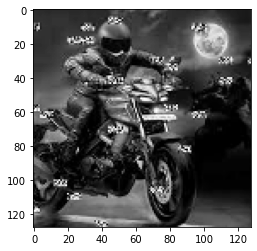

In [13]:
image, class_idx = train_dataset[0]

print('Image shape:', image.shape)
print('Class idx:', class_idx)
print('Class name:', train_dataset.idx_to_class_name[class_idx])

plt.imshow(image[0], cmap='Greys_r')

In [14]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,  # обучающие данные стоит передавать в случайном порядке
    num_workers=2,  # число потоков подготовки данных. если не удается полностью задействовать GPU, то можно попробовать увеличить, но это увеличит нагрузку на cpu
    pin_memory=True,  # перевод GPU памяти в режим pinned ускоряет загрузку/выгрузку данных
    drop_last=True  # чтобы все батчи были одного размера, лучше сделать True
)

test_dataloader = DataLoader(
    test_dataset,  
    batch_size=8, 
    shuffle=False,
    num_workers=1, 
    pin_memory=True, 
    drop_last=False  # чтобы обработать все тестовые данные
)

Объект класса DataLoader является итерируемым и возвращает батчи данных

In [15]:
for batch in test_dataloader:
    break

In [16]:
image_batch, class_idx_batch = batch

print('Image batch size:', image_batch.shape)
print('Class index batch size:', class_idx_batch.shape)

Image batch size: torch.Size([8, 3, 128, 128])
Class index batch size: torch.Size([8])


## Подготовка модели

В качестве модели будем использовать ResNet18, предобученную на датасете ImageNet:

In [17]:
model = resnet18(pretrained=True)

In [18]:
with open('../../pytorch_inference/notebooks/imagenet1000_clsidx_to_labels.json', 'r') as f:
    imagenet1k_clsidx_to_labels = json.load(f)

Проверим, какие результаты показывает предобученная модель до дообучения:

In [19]:
logits = model(image_batch)
topk = torch.topk(logits, 5)

/mnt/shared/progs/miniconda3/envs/py3.8/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [20]:
def show_res(idx):
    plt.imshow(image_batch[idx, 0], cmap='Greys_r')
    print('True label:', train_dataset.idx_to_class_name[class_idx_batch[idx]])
    print('Model labels:', [imagenet1k_clsidx_to_labels[i] for i in topk.indices[idx]])

True label: bike
Model labels: ['pot', 'vine snake', 'junco', 'green mamba', 'European green lizard']


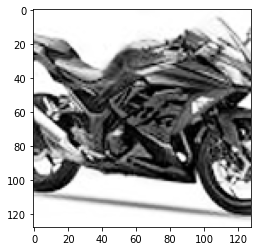

In [21]:
show_res(0)

True label: bike
Model labels: ['American robin', 'chainsaw', 'goldfish', 'barn spider', 'southern black widow']


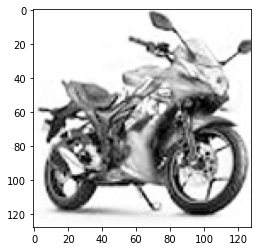

In [22]:
show_res(1)

True label: bike
Model labels: ['water bottle', 'salt shaker', 'water jug', 'coffeemaker', 'milk can']


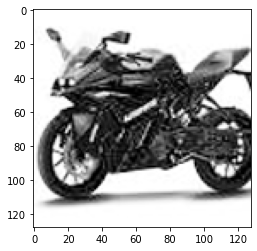

In [23]:
show_res(2)

В целевом датасете 9 классов, поэтому заменим последний слой

In [24]:
model.fc = nn.Linear(512, 9)
torch.nn.init.xavier_normal_(model.fc.weight)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Большая часть модели (кроме последнего слоя), уже достаточно хорошо обучена. Последний слой при этом инициализирован случайными величинами. Поэтому, чтобы в процессе обучения не испортить уже обученные веса, можно их заморозить и дообучить только последний слой:

In [25]:
# Замораживаем все веса модели
for param in model.parameters():
    param.requires_grad = False

# Размораживаем последний линейный слой
for param in model.fc.parameters():
    param.requires_grad = True

При этом полное число параметров модели будет составлять

In [26]:
print('Total number of parameters:', sum(param.numel() for param in model.parameters()))

Total number of parameters: 11181129


Из которых обучаемыми являются всего 512 * 9 + 9 = 4617

In [27]:
print('Number of trainable parameters:', sum(param.numel() for param in model.parameters() if param.requires_grad))

Number of trainable parameters: 4617


In [28]:
if torch.cuda.is_available():
    model = model.cuda()

## Обучение

Для обучения необходимо создать оптимизатор, он будет обновлять веса, для которых requires_grad = True, в процессе обучения. Кроме SGD можно использовать другие доступные оптимизаторы (https://pytorch.org/docs/stable/optim.html), или реализовать свой.

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Параметры SGD необходимо аккуратно подбирать. Рекомендации приведены в работе: https://arxiv.org/abs/1803.09820. Либо сделать выбор в сторону адаптивных методов (Adam, ...)

Оптимизатор, также как и модели, содержит state_dict, содержащий параметры оптимизатора. Его можно сохранить на диск и загрузить обратно в точности так же, как и веса модели.

Изменение параметров (learning_rate, momentum, и т.д.) напрямую влияет на процесс обучения

In [30]:
sd = optimizer.state_dict()
sd['param_groups'][0]['lr'], sd['param_groups'][0]['momentum']

(0.001, 0.9)

Можно изменять их напрямую, но более правильным является использование scheduler (см. https://pytorch.org/docs/stable/optim.html)
Больше методов изменения скорости обучения доступно в https://pytorch.org/ignite/handlers.html#parameter-scheduler

В качестве показателя качества будем использовать точность классификации (accuracy). Результаты её вычисления будем отправлять на wandb сервер

In [32]:
def accuracy_wb(dataloader, model, label):
    model = model.eval()
    tp = 0
    with torch.no_grad():
        for batch in dataloader:
            image_batch, class_idx_batch = batch
            if torch.cuda.is_available():
                image_batch = image_batch.cuda()
                class_idx_batch = class_idx_batch.cuda()
            
            logits = model(image_batch)
            classes = torch.argmax(logits, dim=1)
            tp += (class_idx_batch == classes).sum().item()

        acc = tp / len(dataloader.dataset)
        wandb.log({label: acc})
        print(label, acc)

Запустим процесс обучения

In [33]:
def train(model, num_epochs, prefix):
    for epoch in range(num_epochs):
        print('\nEpoch', epoch)
        model = model.train()

        for batch in train_dataloader:
            # в pytorch градиент хранится в переменной grad и вычисляется при вызове backward
            # при этом он не перезаписывается, а добавляется к старому значению,
            # поэтому необходимо приравнять grad нулю, перед вычислением градиентов
            optimizer.zero_grad()
            
            image_batch, class_idx_batch = batch
            if torch.cuda.is_available():
                image_batch = image_batch.cuda()
                class_idx_batch = class_idx_batch.cuda()

            logits = model(image_batch)

            # вычисляем функцию потерь
            loss = F.cross_entropy(logits, class_idx_batch)

            # вычисляем градиенты
            loss.backward()

            wandb.log({'train_loss': loss})

            # выполняем шаг оптимизации - обновляем веса
            optimizer.step()

        # считаем и логируем метрики качества
        accuracy_wb(train_dataloader, model, 'train_accuracy')
        accuracy_wb(test_dataloader, model, 'test_accuracy')

        # сохраняем промежуточные результаты обучения - веса модели и состояние оптимизатора,
        # чтобы при необходимости возобновить обучение с них
        torch.save(model.state_dict(), prefix + 'model_{}.pth'.format(epoch))
        torch.save(optimizer.state_dict(), prefix + 'optimizer_{}.pth'.format(epoch))

## Stage 1 - обучение линейного слоя

In [34]:
train(model, 20, 'stage_1_')


Epoch 0
train_accuracy 0.4188034188034188
test_accuracy 0.3888888888888889

Epoch 1
train_accuracy 0.5961538461538461
test_accuracy 0.5416666666666666

Epoch 2
train_accuracy 0.6837606837606838
test_accuracy 0.6666666666666666

Epoch 3
train_accuracy 0.7243589743589743
test_accuracy 0.6666666666666666

Epoch 4
train_accuracy 0.7649572649572649
test_accuracy 0.75

Epoch 5
train_accuracy 0.7905982905982906
test_accuracy 0.7361111111111112

Epoch 6
train_accuracy 0.8141025641025641
test_accuracy 0.75

Epoch 7
train_accuracy 0.8333333333333334
test_accuracy 0.75

Epoch 8
train_accuracy 0.8418803418803419
test_accuracy 0.7777777777777778

Epoch 9
train_accuracy 0.8333333333333334
test_accuracy 0.75

Epoch 10
train_accuracy 0.8226495726495726
test_accuracy 0.75

Epoch 11
train_accuracy 0.8461538461538461
test_accuracy 0.8333333333333334

Epoch 12
train_accuracy 0.844017094017094
test_accuracy 0.7916666666666666

Epoch 13
train_accuracy 0.8632478632478633
test_accuracy 0.7916666666666666

Ep

## Stage 2 - дообучение последнего сверточного слоя

Загрузим веса, например, с 18-ой эпохи

In [35]:
model.load_state_dict(torch.load('stage_1_model_18.pth'))
optimizer.load_state_dict(torch.load('stage_1_optimizer_18.pth'))

Разморозим дополнительно последний сверточный слой

In [36]:
for param in model.layer4.parameters():
    param.requires_grad = True

Количество обучаемых параметров при этом составит

In [37]:
print('Number of trainable parameters:', sum(param.numel() for param in model.parameters() if param.requires_grad))

Number of trainable parameters: 8398345


Также уменьшим скорость обучения, например в 10 раз

In [38]:
sd = optimizer.state_dict()
sd['param_groups'][0]['lr'] = 0.0001
optimizer.load_state_dict(sd)

In [39]:
train(model, 20, 'stage_2_')


Epoch 0
train_accuracy 0.8974358974358975
test_accuracy 0.7777777777777778

Epoch 1
train_accuracy 0.9038461538461539
test_accuracy 0.8055555555555556

Epoch 2
train_accuracy 0.9102564102564102
test_accuracy 0.8055555555555556

Epoch 3
train_accuracy 0.9294871794871795
test_accuracy 0.7916666666666666

Epoch 4
train_accuracy 0.9358974358974359
test_accuracy 0.7916666666666666

Epoch 5
train_accuracy 0.9508547008547008
test_accuracy 0.75

Epoch 6
train_accuracy 0.9487179487179487
test_accuracy 0.7638888888888888

Epoch 7
train_accuracy 0.9658119658119658
test_accuracy 0.75

Epoch 8
train_accuracy 0.9465811965811965
test_accuracy 0.8194444444444444

Epoch 9
train_accuracy 0.9572649572649573
test_accuracy 0.7916666666666666

Epoch 10
train_accuracy 0.9615384615384616
test_accuracy 0.8055555555555556

Epoch 11
train_accuracy 0.9700854700854701
test_accuracy 0.7916666666666666

Epoch 12
train_accuracy 0.9636752136752137
test_accuracy 0.7777777777777778

Epoch 13
train_accuracy 0.9679487179

## Бонус: аккумулирование градиентов

In [40]:
wandb.init(project="raai-cv-2021")
None

train_loss,0.3744
_runtime,546
_timestamp,1626245733
_step,2399
train_accuracy,0.97222
test_accuracy,0.76389


train_loss,██▆▄▄▄▄▅▃▂▂▂▂▂▂▅▂▂▁▃▁▂▃▃▂▃▃▃▁▁▁▁▂▂▁▁▁▁▃▂
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▃▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████
test_accuracy,▁▃▅▅▆▆▆▆▇▆▆█▇▇▇▇▆▆▇▆▇▇▇▇▇▆▇▆▇▇▇▇▇█▇▇▇▇█▇


Как правило, обучение моделей производится на нескольких GPU с большим размером батча. В условиях ограниченных ресурсов приходится уменьшать размер батча. Это приводит к более зашумленной оценке градиента и, зачастую, более низким показателям качества итоговой модели. Стандартной рекомендацией является пропорциональное уменьшение скорости обучения. То есть, при уменьшении размера батча в 8 раз, стоит уменьшить learning rate в 8 раз. Это правило эмпирическое и не гарантирует результат.

Другим выходом является аккумулирование градиентов. Оно заключается в вычислении среднего градиента по нескольким батчам, с последующим выполнением шага оптимизации

In [41]:
def train_ga(model, num_epochs, prefix, num_steps):
    for epoch in range(num_epochs):
        print('\nEpoch', epoch)
        model = model.train()

        optimizer.zero_grad()

        for i, batch in enumerate(train_dataloader):
            image_batch, class_idx_batch = batch
            if torch.cuda.is_available():
                image_batch = image_batch.cuda()
                class_idx_batch = class_idx_batch.cuda()

            logits = model(image_batch)

            # вычисляем функцию потерь
            loss = F.cross_entropy(logits, class_idx_batch) / num_steps

            # вычисляем градиенты
            # в pytorch градиент хранится в переменной grad и вычисляется при вызове backward
            # при этом он не перезаписывается, а добавляется к старому значению
            loss.backward()

            wandb.log({'train_loss': loss})

            if (i + 1) % num_steps == 0:
                # выполняем шаг оптимизации - обновляем веса
                optimizer.step()
                optimizer.zero_grad()

        # считаем и логируем метрики качества
        accuracy_wb(train_dataloader, model, 'train_accuracy')
        accuracy_wb(test_dataloader, model, 'test_accuracy')

        # сохраняем промежуточные результаты обучения - веса модели и состояние оптимизатора,
        # чтобы при необходимости возобновить обучение с них
        torch.save(model.state_dict(), prefix + 'model_{}.pth'.format(epoch))
        torch.save(optimizer.state_dict(), prefix + 'optimizer_{}.pth'.format(epoch))

In [42]:
model.fc = nn.Linear(512, 9)
torch.nn.init.xavier_normal_(model.fc.weight)

if torch.cuda.is_available():
    model = model.cuda()

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [43]:
train_ga(model, 50, 'ga_', 10)


Epoch 0
train_accuracy 0.07264957264957266
test_accuracy 0.08333333333333333

Epoch 1
train_accuracy 0.09188034188034189
test_accuracy 0.1388888888888889

Epoch 2
train_accuracy 0.10683760683760683
test_accuracy 0.16666666666666666

Epoch 3
train_accuracy 0.17735042735042736
test_accuracy 0.2361111111111111

Epoch 4
train_accuracy 0.23717948717948717
test_accuracy 0.2361111111111111

Epoch 5
train_accuracy 0.2670940170940171
test_accuracy 0.2638888888888889

Epoch 6
train_accuracy 0.358974358974359
test_accuracy 0.3333333333333333

Epoch 7
train_accuracy 0.4017094017094017
test_accuracy 0.4305555555555556

Epoch 8
train_accuracy 0.41239316239316237
test_accuracy 0.5416666666666666

Epoch 9
train_accuracy 0.5235042735042735
test_accuracy 0.5416666666666666

Epoch 10
train_accuracy 0.5363247863247863
test_accuracy 0.5694444444444444

Epoch 11
train_accuracy 0.5982905982905983
test_accuracy 0.5972222222222222

Epoch 12
train_accuracy 0.6324786324786325
test_accuracy 0.625

Epoch 13
train